In [1]:
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from sklearn.preprocessing import MultiLabelBinarizer

pd.options.display.float_format = '{:,.2f}'.format

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
# Para o Modelo
import tensorflow as tf
import keras
from keras import backend as K
from keras.applications.vgg19 import VGG19
from keras.optimizers import *
from keras.callbacks import *
from keras.metrics import top_k_categorical_accuracy
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

/home/andre/.conda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Processando os dados

## Gerados com Penelope

In [3]:
files =  glob.glob("../dados_v[4-5]/*.dat")

In [4]:
len(files)

758

In [5]:
def le_performance_report(filename):
    # 164000
    # Performance report
    #   Random seeds:
    #   1800926990
    #   1275941380
    #   No. of histories simulated [N]:
    #            10000000.
    #   CPU time [t] (s):
    #    3.28417E+01
    #   Speed (histories/s):
    #    3.04491E+05
    #   Average uncertainty (above 1/2 max score) in % [uncert]:
    #    1.27128E-01
    #   Intrinsic efficiency [N*uncert^2]^-1:
    #    6.18758E-06
    #   Absolute efficiency [t*uncert^2]^-1:
    #    1.88406E+00
    
    with open(filename, "r") as f:
        linhas = f.readlines()
    try:
        return float(linhas[16400+7][1:])
    except:
        return float(linhas[16400+6][1:])

def carrega_dados(filename, n_particulas=1.0e07):
    data = {
        'Elow(eV)' : [],
        'Emiddle(eV)' : [],
        'counts(1/eV/hist)' : [],
        '+-2sigma':[],
        'nbin' : []
    }

    linha_de_dados = False
    with open(filename, "r") as f:
        for line in f:
            if line[0] == '#':
                linha_de_dados = False
            else:
                linha_de_dados = True

            if linha_de_dados:
                aux = line.split(' ')
                if len(aux) == 2:
                    break

                data['Elow(eV)'].append(np.fromstring(aux[2], dtype=np.float64, sep=',')[0])
                data['Emiddle(eV)'].append(np.fromstring(aux[4], dtype=np.float64, sep=',')[0])
                q = np.fromstring(aux[6], dtype=np.float64, sep=',')[0]
                data['counts(1/eV/hist)'].append(q)
                data['+-2sigma'].append(np.fromstring(aux[8], dtype=np.float64, sep=',')[0])
                nbin = np.fromstring(aux[9], dtype=np.int, sep=',')[0]
                data['nbin'].append(nbin)      

    df = pd.DataFrame.from_dict(data)
    df['counts'] = df['counts(1/eV/hist)'].values * n_particulas * 1 / ((df['Elow(eV)'].shift(-1).fillna(0) - df['Elow(eV)']) / df['nbin'])
    df['counts'] = df['counts']#.astype(np.uint8)
    df['counts'][0:20] = 0
    df['E'] = df['Elow(eV)'] / 1e3
    return df.loc[0:16383]

In [6]:
tempo_segundos = 0

for file_ in files:
    tempo_segundos += le_performance_report(file_)
    
print("Total de tempo de CPU utilizado: {0} dias".format(tempo_segundos / 60 / 60 / 24))

Total de tempo de CPU utilizado: 377.7199294814816 dias


In [7]:
energias_iniciais_multicanal = ['-1', '1', '250', '400', '150', '300', '0']
#energias_iniciais_multicanal = ['0-01.dat']
#energias_iniciais_multicanal = ['0-01.dat', '5-0.dat', '10-0.dat', '30-0.dat', '40-0.dat']
#energias_iniciais_multicanal = ['0-01.dat']

In [8]:
nomes_nuclideos = {
    'Am-241': 0,
    'Ba-133': 1,
    'Cd-109': 2,
    'Co-57': 3,
    'Co-60': 4,
    'Cs-137': 5,
    'Eu-152': 6,
    'Mn-54': 7,
    'Na-22': 8,
    'Pb-210': 9
}

binarizer = MultiLabelBinarizer()
binarizer.fit([list(nomes_nuclideos.keys())])
binarizer.classes_

array(['Am-241', 'Ba-133', 'Cd-109', 'Co-57', 'Co-60', 'Cs-137', 'Eu-152',
       'Mn-54', 'Na-22', 'Pb-210'], dtype=object)

In [9]:
# Cd-109_41cm_1-0e08estories_0-01.dat
dados_por_energia_inicial_multicanal = dict()

for energia_inicial_multicanal in energias_iniciais_multicanal:
    dados_por_energia_inicial_multicanal[energia_inicial_multicanal] = []
    
    for file_ in tqdm_notebook(files):
        if not file_.endswith('_'+energia_inicial_multicanal+'.dat'):
            continue
        
        partes = file_.split("/")[2].replace(".dat", "").split("_")
        nuclideo = partes[0]        
        distancia = partes[1]
        
        n_particulas_simulacao = float(partes[2].replace('estories','').replace('-','.'))
        
        # diferentes atividades
        for n_particulas in [1e3, 1e6, 1e9, 3e3, 3e6, 3e9, 8e3, 8e6, 8e9, n_particulas_simulacao]:
        
            dados_ = carrega_dados(file_, n_particulas)

            label_ = binarizer.transform([[nuclideo]])

            #Cria o label para o total de contagens do radionuclídeo
            #total_counts = np.zeros(label_.shape)
            #total_counts[0][np.argmax(label_)] = np.sum(dados_.counts.values)

            atividade = np.zeros(label_.shape)
            atividade[0][np.argmax(label_)] = n_particulas
            
            dados_por_energia_inicial_multicanal[energia_inicial_multicanal].append({
                'X' : dados_.counts.values,
                'n' : atividade,
                'y': label_,
                #'y_count' : total_counts,
                'd': distancia,
                'e': energia_inicial_multicanal
            })

/home/andre/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
a = 0
for k in dados_por_energia_inicial_multicanal:
    print(k, len(dados_por_energia_inicial_multicanal[k]))
    a += len(dados_por_energia_inicial_multicanal[k])
a

-1 400
1 1200
250 1190
400 1200
150 1200
300 1200
0 1190


7580

## Leituras experimentais da GRR

In [11]:
def obtem_dados_dos_canais(linhas):
    dados = []
    pode_comecar = False
    for linha in linhas:
        if linha == "A004USERDEFINED                                                     \n":
            pode_comecar = True
            continue
        if pode_comecar:
            aux = linha.strip().split()
            if int(aux[1]) % 5:
                print("oi!")
            dados.extend([float(x) for x in aux[2:]])
    return dados[1:]

In [12]:
arquivos = ['Am-241 - BG.IEC', 'Ba-133 - BG.IEC', 'Cd-109 - BG.IEC', 'Co-57 - BG.IEC', 'Co-60 - BG.IEC',
            'Cs-137 - BG.IEC', 'Eu-152 - BG.IEC', 'Mn-54 - BG.IEC', 'Na-22 - BG.IEC', 'Pb-210 - BG.IEC',]

df_nuclideos = dict()
img_espectros = dict()
img_convertidos = dict()
images = dict()

for arquivo in arquivos:
    print(arquivo)
    dados = []

    with open('/export/ipen/artigo/ICDA-3/Espectros/Experimentos/17-Maio-2018/Espectros/{0}'.format(arquivo), 'r') as f:
        dados = f.readlines()
    dados = obtem_dados_dos_canais(dados)
    df = pd.DataFrame({'channel': range(0, len(dados)), 'counts' : dados})
    df_nuclideos[arquivo] = df.copy()
    img_convertidos[arquivo] = np.array(dados).reshape((128, 128)).copy()
    images[arquivo.split(' ')[0]] = np.array(dados).reshape((128, 128)).copy()

Am-241 - BG.IEC
Ba-133 - BG.IEC
Cd-109 - BG.IEC
Co-57 - BG.IEC
Co-60 - BG.IEC
Cs-137 - BG.IEC
Eu-152 - BG.IEC
Mn-54 - BG.IEC
Na-22 - BG.IEC
Pb-210 - BG.IEC


In [13]:
arquivo_por_nome = { b : b.split()[0] for a, b in enumerate(list(img_convertidos.keys()))}
nome_por_arquivo = { b.split()[0] : b for a, b in enumerate(list(img_convertidos.keys()))}

id_para_radionuclideos = { a : b.split()[0] for a, b in enumerate(list(img_convertidos.keys()))}
radionuclideos = { b.split()[0] : a for a, b in enumerate(list(img_convertidos.keys()))}
arquivo_por_nome, nome_por_arquivo, id_para_radionuclideos, radionuclideos

({'Am-241 - BG.IEC': 'Am-241',
  'Ba-133 - BG.IEC': 'Ba-133',
  'Cd-109 - BG.IEC': 'Cd-109',
  'Co-57 - BG.IEC': 'Co-57',
  'Co-60 - BG.IEC': 'Co-60',
  'Cs-137 - BG.IEC': 'Cs-137',
  'Eu-152 - BG.IEC': 'Eu-152',
  'Mn-54 - BG.IEC': 'Mn-54',
  'Na-22 - BG.IEC': 'Na-22',
  'Pb-210 - BG.IEC': 'Pb-210'},
 {'Am-241': 'Am-241 - BG.IEC',
  'Ba-133': 'Ba-133 - BG.IEC',
  'Cd-109': 'Cd-109 - BG.IEC',
  'Co-57': 'Co-57 - BG.IEC',
  'Co-60': 'Co-60 - BG.IEC',
  'Cs-137': 'Cs-137 - BG.IEC',
  'Eu-152': 'Eu-152 - BG.IEC',
  'Mn-54': 'Mn-54 - BG.IEC',
  'Na-22': 'Na-22 - BG.IEC',
  'Pb-210': 'Pb-210 - BG.IEC'},
 {0: 'Am-241',
  1: 'Ba-133',
  2: 'Cd-109',
  3: 'Co-57',
  4: 'Co-60',
  5: 'Cs-137',
  6: 'Eu-152',
  7: 'Mn-54',
  8: 'Na-22',
  9: 'Pb-210'},
 {'Am-241': 0,
  'Ba-133': 1,
  'Cd-109': 2,
  'Co-57': 3,
  'Co-60': 4,
  'Cs-137': 5,
  'Eu-152': 6,
  'Mn-54': 7,
  'Na-22': 8,
  'Pb-210': 9})

In [ ]:
#plt.plot(np.random.poisson(1e5, (128, 128)))
#plt.plot(np.random.normal(1, 0.1**0.5, (128, 128)))

In [14]:
def add_noise(image):
    #if random.random() <= 0.5:
    #    return image.reshape((128, 128, 1))
    row,col = image.shape
    mean = 1 #np.mean(image)
    var = 0.1 #random.random() #
    sigma = var**0.5
    gauss = np.random.normal(mean, sigma, (row,col))
    gauss = gauss.reshape(row, col)
    noisy = image + gauss
    if np.random.random() > 0.3:
        #increase de count rate by a random factor
        noisy += noisy * (1 + np.random.random())
    return noisy.reshape((128, 128, 1)) #/ np.max(noisy) # normalizando pelo valor máximo


#def gera_imagem_combinada_experimental(dicionario_imagens, n_combinacoes=3):
#    assert n_combinacoes <= 10, "No máximo 10 combinações"
#    nuclei_idx = np.random.choice(10, n_combinacoes, replace=False).tolist()[0]
#    label = to_categorical(nuclei_idx, 10)
#    img = np.sum([add_noise(dicionario_imagens[id_para_radionuclideos[nuclei_idx]])], axis=0)
#    counts = to_categorical(nuclei_idx, 10)
#    counts[nuclei_idx] = np.sum(img)
#    
#    return img, label, counts

def gera_imagem_combinada_experimental(dicionario_imagens,
                                       n_combinacoes=1):
    
    assert n_combinacoes <= 10, "No máximo 10 combinações"
    
    a = np.random.choice(10, n_combinacoes, replace=False).tolist()
    labels = np.sum([to_categorical(x, 10) for x in a], axis=0)
    noise_img = [add_noise(dicionario_imagens[id_para_radionuclideos[x]]) for x in a]
    img = np.sum(noise_img, axis=0)
    
    counts = np.zeros((10,))
    for idx, item in enumerate(a):
        counts[item] = np.sum(noise_img[idx])
    
    while np.max(labels) > 1: # temos nuclideo repetido
        labels[0][np.argmax(labels[0])] = 1
    
    return img, labels, counts


# Gerando conjunto de treino e validação

## Com os dados experimentais

In [54]:
X = []
y = []
y_counts = []
ids = []

In [55]:
# gerando imagens com mais de um espectro
n_combinacoes = [1, 2, 3, 4]
for n_combinacao in n_combinacoes:
    for i in range(500):
        img, label, counts = gera_imagem_combinada_experimental(images, n_combinacao)
        X.append(img)
        y.append(label)
        y_counts.append(counts)
        ids.append({'tipo': 'experimental'})

In [47]:
len(X), len(y), len(y_counts), len(ids)

(2000, 2000, 2000, 2000)

## Com os dados gerados pelo PENELOPE

In [48]:
def gera_imagem_combinada_penelope(dicionario_imagens, n_combinacoes=3):
    assert n_combinacoes <= 10, "No máximo 10 combinações"

    aux = np.random.choice(dicionario_imagens, n_combinacoes, replace=False)
    #print(aux)
    labels = np.sum([x['y'] for x in aux], axis=0)
    counts = np.sum([x['n'] for x in aux], axis=0)
    values = np.sum([x['X'] for x in aux], axis=0)
    
    while np.max(labels) > 1: # temos nuclideo repetido
        labels[0][np.argmax(labels[0])] = 1
    
    id_instancia = {'tipo': 'penelope_multiplo', 'meta': aux}
    
    return values, labels, counts, id_instancia

### Gera espectros com mais de um radionuclideo

Até 4 no mesmo espectro

In [49]:
n_combinacoes = [2, 3, 4]
novos_dados = dict()

for key in energias_iniciais_multicanal:
    novos_dados[key] = []
    for n_ in n_combinacoes:
        for i in range(800):
            values, labels, counts, id_instancia = gera_imagem_combinada_penelope(dados_por_energia_inicial_multicanal[key],
                                                  n_)
            novos_dados[key].append({'X' : values,
                                     'y': labels,
                                     'n': counts,
                                     'id': id_instancia})

In [56]:
for key in energias_iniciais_multicanal:
    for item in dados_por_energia_inicial_multicanal[key]:
        X.append(list(item.values())[0].reshape((128, 128)))
        y.append(item['y'][0])
        y_counts.append(item['n'][0])
        ids.append(item.get("id", {'tipo': 'penelope_original', 'meta': item}))

In [57]:
for key in energias_iniciais_multicanal:
    for item in novos_dados[key]:
        X.append(list(item.values())[0].reshape((128, 128)))
        y.append(item['y'][0])
        y_counts.append(item['n'][0])
        ids.append(item.get("id", {'tipo': 'penelope_original', 'meta': item}))

In [58]:
len(X), len(y), len(y_counts), len(ids)

(26380, 26380, 26380, 26380)

In [60]:
!rm -rf ./dados_v1_atividade
!mkdir ./dados_v1_atividade
np.save("./dados_v1_atividade/X.npy", [x.reshape((128,128,1)) for x in X])
np.save("./dados_v1_atividade/y.npy", y)
np.save("./dados_v1_atividade/y_counts.npy", y_counts)
np.save("./dados_v1_atividade/ids.npy", np.array(ids))

In [ ]:
X = np.load("./dados_v1_atividade/X.npy")
y = np.load("./dados_v1_atividade/y.npy")
y_counts = np.load("./dados_v1_atividade/y_counts.npy")

# Modelo

## Dividindo os dados em treino e teste

In [61]:
#scaler = StandardScaler()
#scaler.fit(y_counts)

X_train, X_test, y_train, y_test = train_test_split(X, list(zip(y, np.log(np.array(y_counts) + 1))),
                                                    test_size=0.30,
                                                    random_state=42)

In [63]:
ids_train, ids_test  = train_test_split(ids,
                                       test_size=0.30,
                                       random_state=42)

In [65]:
len(X_train), len(y_train), len(ids_train), len(X_test), len(y_test), len(ids_test)

(18466, 18466, 18466, 7914, 7914, 7914)

In [66]:
from keras.utils import Sequence

In [67]:
class EspectraSequence(Sequence):

    def __init__(self, x_set, y_set, y_set_count, batch_size):
        self.x, self.y, self.y_set_count = x_set, y_set, y_set_count
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y_count = self.y_set_count[idx * self.batch_size:(idx + 1) * self.batch_size]

        y_ = {'predictions_nuclei': np.array(batch_y, dtype=np.float32),
              'predictions_counts': np.array(batch_y_count)}
        
        return np.array([x.reshape((128, 128, 1)) for x in batch_x]), y_

In [68]:
s = EspectraSequence(X_train, [x[0] for x in y_train], [x[1] for x in y_train], batch_size=8)

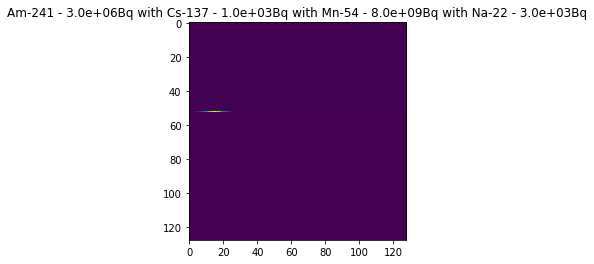

In [69]:
a, b = s[2]
c = b['predictions_counts']
b = b['predictions_nuclei']
plt.imshow(a[0].reshape((128, 128)))
title_data = list(zip(binarizer.inverse_transform(np.array([b[0]]))[0], np.exp(c[0])[np.array([b[0]]).astype(np.bool)[0]]))
plt.title(" with ".join(["{} - {:.1e}Bq".format(x[0], x[1]) for x in title_data]))
plt.show()

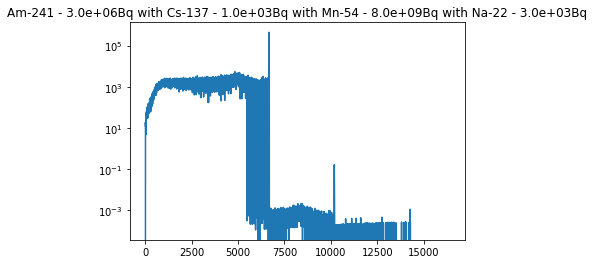

In [70]:
title_data = list(zip(binarizer.inverse_transform(np.array([b[0]]))[0], np.exp(c[0])[np.array([b[0]]).astype(np.bool)[0]]))
plt.title(" with ".join(["{} - {:.1e}Bq".format(x[0], x[1]) for x in title_data]))
plt.plot(a[0].reshape(-1))
plt.yscale("log")
plt.show()

In [71]:
def accuracy_score_wrapper(label, pred):
    threshold = .95
    label = (label >= threshold).astype(np.uint8)
    pred = (pred >= threshold).astype(np.uint8)
    return np.float32(accuracy_score(label, pred))

def my_accuracy_score(label, pred):
    metric_value = tf.compat.v1.py_func(accuracy_score_wrapper, [label, pred], tf.float32)
    return metric_value

In [247]:
K.clear_session()
import keras
vgg_model = VGG19(include_top=False,
                  weights=None,
                  input_shape=(128, 128, 1),
                  classes=10)

x = keras.layers.Flatten()(vgg_model.output)
x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.Dense(4096, activation='relu')(x)
pred_nuclei = keras.layers.Dense(10, activation='sigmoid', name="predictions_nuclei")(x)

x1 = keras.layers.Flatten()(vgg_model.output)
x1 = keras.layers.Dense(4096, activation='relu')(x1)
x1 = keras.layers.Dense(4096, activation='relu')(x1)
pred_counts = keras.layers.Dense(10, activation=None, name="predictions_counts")(x1)


#pred_counts = keras.layers.Dense(4096, activation='elu')(x1)
#pred_counts = keras.layers.Dense(2048, activation='elu')(pred_counts)


#se a previsão do modelo for menor que zero, a gente zera a saída, afinal de contas
#não existe atividade 0 bq :P
#pred_counts = keras.layers.Lambda(lambda x: tf.where(x < 0, tf.zeros_like(x), x),
#                                 name="predictions_counts")(pred_counts)

model = keras.models.Model(vgg_model.input, [pred_nuclei, pred_counts])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 128, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 64, 64, 64)   0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [248]:
learning_rate = 1e-5
epochs = 250
batch_size = 8
steps_per_epoch = len(X_train) // batch_size + 1
validation_steps = len(X_test) // batch_size + 1

In [249]:
opt = SGD(lr=learning_rate,
          nesterov=False,
          momentum=0.9) # keras.optimizers.RMSprop(0.001)

model.compile(optimizer=Adam(lr=1e-4),
              loss={
                  'predictions_nuclei': 'binary_crossentropy',
                  'predictions_counts': 'mean_squared_error'
              },
              metrics={
                  'predictions_nuclei': [my_accuracy_score, 'accuracy'],
                  'predictions_counts': ['mean_squared_error', 'mean_absolute_error']
              }
             )

In [250]:
!nvidia-smi

Mon Jul  6 20:17:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.48                 Driver Version: 410.48                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   33C    P8     9W / 180W |   7957MiB /  8117MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [251]:
!rm -rf ./logsv1_atividade
!mkdir ./logsv1_atividade

In [252]:
from keras.callbacks import LearningRateScheduler

In [253]:
import math
def step_decay(epoch):
    initial_lrate = 1e-5
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [254]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='VGG-19-Adam-classificacao-regressao-PENELOPE-v1_atividade.hdf5',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [255]:
gerador_treino = EspectraSequence(X_train, [x[0] for x in y_train], [x[1] for x in y_train], batch_size=batch_size)
#gerador_imagens(X_train, y_train, batch_size=batch_size)

gerador_validacao = EspectraSequence(X_test, [x[0] for x in y_test], [x[1] for x in y_test], batch_size=batch_size)
#gerador_imagens(X_test, y_test, batch_size=batch_size)

es = keras.callbacks.EarlyStopping(monitor='val_loss',
                                   mode='min',
                                   patience=20)

lrate = LearningRateScheduler(step_decay)

tb = keras.callbacks.TensorBoard(
    log_dir='./logsv1_atividade',
    histogram_freq=0,
    #batch_size=32,
    write_graph=True,
    #batch_gen=gerador_validacao,
    #nb_steps=validation_steps,
    update_freq='epoch')

#EspectraSequence(X_train, [x[0] for x in y_train], [x[1] for x in y_train], batch_size=8)

callbacks = [es, tb, model_checkpoint_callback] #, lrate]

hist = model.fit_generator(generator=gerador_treino,
                           steps_per_epoch=steps_per_epoch,
                           epochs=epochs,
                           verbose=2,
                           callbacks=callbacks,
                           validation_data=gerador_validacao, #(x_train_val, y_train_val),
                           validation_steps=validation_steps,
                           shuffle=True)


Epoch 1/250
 - 316s - loss: 38.5214 - predictions_nuclei_loss: 0.4249 - predictions_counts_loss: 38.0965 - predictions_nuclei_my_accuracy_score: 0.0963 - predictions_nuclei_acc: 0.8439 - predictions_counts_mean_squared_error: 38.0965 - predictions_counts_mean_absolute_error: 3.5149 - val_loss: 16.7988 - val_predictions_nuclei_loss: 0.3183 - val_predictions_counts_loss: 16.4805 - val_predictions_nuclei_my_accuracy_score: 0.2177 - val_predictions_nuclei_acc: 0.8926 - val_predictions_counts_mean_squared_error: 16.4805 - val_predictions_counts_mean_absolute_error: 2.4203
Epoch 2/250
 - 316s - loss: 13.3991 - predictions_nuclei_loss: 0.2581 - predictions_counts_loss: 13.1410 - predictions_nuclei_my_accuracy_score: 0.3319 - predictions_nuclei_acc: 0.9133 - predictions_counts_mean_squared_error: 13.1410 - predictions_counts_mean_absolute_error: 2.0638 - val_loss: 11.6932 - val_predictions_nuclei_loss: 0.2344 - val_predictions_counts_loss: 11.4588 - val_predictions_nuclei_my_accuracy_score: 0.

Epoch 16/250
 - 316s - loss: 5.5034 - predictions_nuclei_loss: 0.1410 - predictions_counts_loss: 5.3624 - predictions_nuclei_my_accuracy_score: 0.6233 - predictions_nuclei_acc: 0.9550 - predictions_counts_mean_squared_error: 5.3624 - predictions_counts_mean_absolute_error: 1.0272 - val_loss: 5.9067 - val_predictions_nuclei_loss: 0.1543 - val_predictions_counts_loss: 5.7524 - val_predictions_nuclei_my_accuracy_score: 0.6042 - val_predictions_nuclei_acc: 0.9539 - val_predictions_counts_mean_squared_error: 5.7524 - val_predictions_counts_mean_absolute_error: 1.0318
Epoch 17/250
 - 316s - loss: 5.3546 - predictions_nuclei_loss: 0.1379 - predictions_counts_loss: 5.2167 - predictions_nuclei_my_accuracy_score: 0.6269 - predictions_nuclei_acc: 0.9557 - predictions_counts_mean_squared_error: 5.2167 - predictions_counts_mean_absolute_error: 1.0081 - val_loss: 5.6514 - val_predictions_nuclei_loss: 0.1523 - val_predictions_counts_loss: 5.4991 - val_predictions_nuclei_my_accuracy_score: 0.6170 - va

Epoch 31/250
 - 316s - loss: 3.7961 - predictions_nuclei_loss: 0.0951 - predictions_counts_loss: 3.7010 - predictions_nuclei_my_accuracy_score: 0.6928 - predictions_nuclei_acc: 0.9668 - predictions_counts_mean_squared_error: 3.7010 - predictions_counts_mean_absolute_error: 0.8559 - val_loss: 6.0488 - val_predictions_nuclei_loss: 0.1884 - val_predictions_counts_loss: 5.8604 - val_predictions_nuclei_my_accuracy_score: 0.6401 - val_predictions_nuclei_acc: 0.9490 - val_predictions_counts_mean_squared_error: 5.8604 - val_predictions_counts_mean_absolute_error: 1.0613
Epoch 32/250
 - 316s - loss: 3.6100 - predictions_nuclei_loss: 0.0903 - predictions_counts_loss: 3.5197 - predictions_nuclei_my_accuracy_score: 0.7023 - predictions_nuclei_acc: 0.9682 - predictions_counts_mean_squared_error: 3.5197 - predictions_counts_mean_absolute_error: 0.8379 - val_loss: 5.8971 - val_predictions_nuclei_loss: 0.1967 - val_predictions_counts_loss: 5.7004 - val_predictions_nuclei_my_accuracy_score: 0.6368 - va

In [261]:
from keras.models import save_model, load_model
#save_model(model, 'VGG-19-Adam-classificacao-regressao-PENELOPE-v1_atividade.hdf5')

In [263]:
model = load_model('VGG-19-Adam-classificacao-regressao-PENELOPE-v1_atividade.hdf5',
                  custom_objects={'my_accuracy_score': my_accuracy_score})

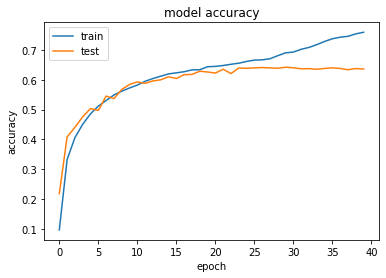

In [256]:
plt.plot(hist.history['predictions_nuclei_my_accuracy_score'])
plt.plot(hist.history['val_predictions_nuclei_my_accuracy_score'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

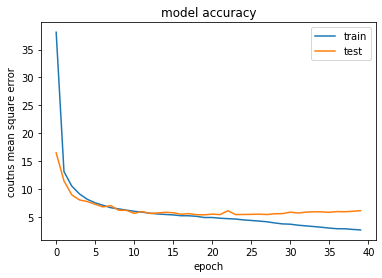

In [257]:
plt.plot(hist.history['predictions_counts_mean_squared_error'])
plt.plot(hist.history['val_predictions_counts_mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('coutns mean square error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

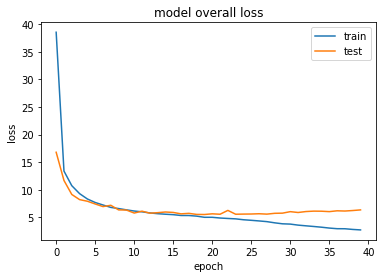

In [258]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model overall loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

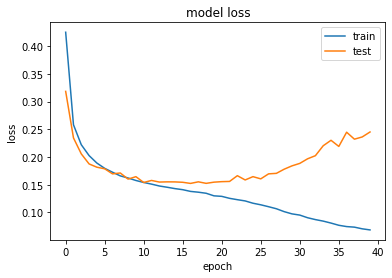

In [259]:
plt.plot(hist.history['predictions_nuclei_loss'])
plt.plot(hist.history['val_predictions_nuclei_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Fine Tunning das partes finais

# Validando nos espectros criados com Penelope

In [217]:
from keras.utils.vis_utils import plot_model

In [146]:
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

664


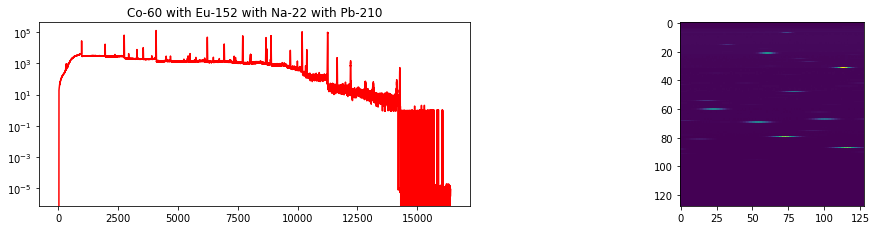

In [264]:
gerador_validacao = EspectraSequence(X_test, [x[0] for x in y_test], [x[1] for x in y_test], batch_size=1)
idx_ = np.random.choice(len(gerador_validacao) - 1, 1)[0]
print(idx_)
x_, aux_ = gerador_validacao[idx_]

y_counts = aux_['predictions_counts']
y_ = aux_['predictions_nuclei']

idx = 0
f, axarr = plt.subplots(1, 2, figsize=(17, 1.7))
axarr[0].plot(range(len(x_[idx].reshape(-1))),
              x_[idx].reshape(-1), 'r')
axarr[0].set_yscale("log")

axarr[0].set_title(" with ".join(binarizer.inverse_transform(np.array([y_[idx]]))[0]))
axarr[1].imshow(x_[0].reshape((128,128)))

plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

In [265]:
preds = model.predict(np.array([x_[idx].reshape((128, 128, 1))]))

In [266]:
df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   #'nuclei_counts': scaler.inverse_transform(preds[1][0]),
                   'nuclei_counts': np.exp(preds[1][0]) - 1,
                   #'real_counts': scaler.inverse_transform(y_counts[idx])
                   'real_counts': np.exp(y_counts[idx]) - 1
                  })
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,24.44,26.46,0.00
1,Ba-133,9.73,3.36,0.00
2,Cd-109,17.28,9.98,0.00
3,Co-57,8.43,1.60,0.00
4,Co-60,5.30,0.55,"3,000.00"
5,Cs-137,10.79,4.79,0.00
6,Eu-152,99.91,"12,897,584,128.00","8,000,000,000.00"
7,Mn-54,17.51,5.27,0.00
8,Na-22,99.72,"2,911,063,296.00","1,000,000,000.00"
9,Pb-210,7.05,1.95,"1,000,000,000.00"


In [ ]:
# Criar uma massa de dados simulando com papel ao invés de água
# Corrigir as contagens na entrada pela eficiência da similação
# Re-treinar

# Validando nos espectros experimentais

In [221]:
def obtem_dados_dos_canais(linhas):
    dados = []
    pode_comecar = False
    for linha in linhas:
        if linha == "A004USERDEFINED                                                     \n":
            pode_comecar = True
            continue
        if pode_comecar:
            aux = linha.strip().split()
            if int(aux[1]) % 5:
                print("oi!")
            dados.extend([float(x) for x in aux[2:]])
    return dados[1:]

In [222]:
arquivos = ['Am-241 - BG.IEC',
            'Ba-133 - BG.IEC',
            'Cd-109 - BG.IEC',
            'Co-57 - BG.IEC',
            'Co-60 - BG.IEC',
            'Cs-137 - BG.IEC',
            'Eu-152 - BG.IEC',
            'Mn-54 - BG.IEC',
            'Na-22 - BG.IEC',
            'Pb-210 - BG.IEC',]

df_nuclideos = dict()
img_espectros = dict()
img_convertidos = dict()
images = dict()

for arquivo in arquivos:
    print(arquivo)
    dados = []

    with open('/export/ipen/artigo/ICDA-3/Espectros/Experimentos/17-Maio-2018/Espectros/{0}'.format(arquivo), 'r') as f:
        dados = f.readlines()
    dados = obtem_dados_dos_canais(dados)
    df = pd.DataFrame({'channel': range(0, len(dados)), 'counts' : dados})
    df_nuclideos[arquivo] = df.copy()
    img_convertidos[arquivo] = np.array(dados).reshape((128, 128)).copy()
    images[arquivo.split(' ')[0]] = np.array(dados).reshape((128, 128)).copy()

Am-241 - BG.IEC
Ba-133 - BG.IEC
Cd-109 - BG.IEC
Co-57 - BG.IEC
Co-60 - BG.IEC
Cs-137 - BG.IEC
Eu-152 - BG.IEC
Mn-54 - BG.IEC
Na-22 - BG.IEC
Pb-210 - BG.IEC


In [ ]:
f, axarr = plt.subplots(10, 2, figsize=(15,25))
for n, arquivo in enumerate(arquivos):
    df = df_nuclideos[arquivo]
    axarr[n, 0].plot(df['channel'], df['counts'], 'r')
    axarr[n, 0].set_title("Espectro : {0}".format(arquivo))
    
    axarr[n, 1].imshow(img_convertidos[arquivo])
    #axarr[n, 1].set_title("Como Imagem : {0}".format(arquivo))
    
plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

In [267]:
preds = model.predict(np.array([images['Am-241'].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': np.exp(preds[1][0]) - 1,
                   'real_counts': np.sum(images['Am-241'])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,99.88,"239,688.64","141,596.00"
1,Ba-133,0.03,-0.05,"141,596.00"
2,Cd-109,0.25,-0.17,"141,596.00"
3,Co-57,0.48,0.30,"141,596.00"
4,Co-60,0.00,-0.13,"141,596.00"
5,Cs-137,0.02,0.06,"141,596.00"
6,Eu-152,0.00,0.05,"141,596.00"
7,Mn-54,0.00,0.01,"141,596.00"
8,Na-22,0.00,0.14,"141,596.00"
9,Pb-210,0.15,-0.24,"141,596.00"


In [268]:
validation_nuclei = 'Ba-133'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': np.exp(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.01,0.71,"35,319.00"
1,Ba-133,99.99,"86,165.91","35,319.00"
2,Cd-109,0.36,0.85,"35,319.00"
3,Co-57,0.00,0.93,"35,319.00"
4,Co-60,0.00,0.99,"35,319.00"
5,Cs-137,0.00,1.29,"35,319.00"
6,Eu-152,0.00,1.03,"35,319.00"
7,Mn-54,0.00,0.93,"35,319.00"
8,Na-22,0.00,0.93,"35,319.00"
9,Pb-210,0.02,0.58,"35,319.00"


In [269]:
validation_nuclei = 'Cd-109'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': np.exp(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.04,0.89,"7,195.00"
1,Ba-133,0.00,0.85,"7,195.00"
2,Cd-109,98.06,708.80,"7,195.00"
3,Co-57,0.05,0.73,"7,195.00"
4,Co-60,0.01,1.21,"7,195.00"
5,Cs-137,0.00,1.30,"7,195.00"
6,Eu-152,0.01,1.21,"7,195.00"
7,Mn-54,0.02,0.96,"7,195.00"
8,Na-22,0.00,1.23,"7,195.00"
9,Pb-210,0.92,1.23,"7,195.00"


In [270]:
validation_nuclei = 'Co-57'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': np.exp(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.40,1.05,"7,323.00"
1,Ba-133,0.02,1.12,"7,323.00"
2,Cd-109,0.30,0.88,"7,323.00"
3,Co-57,100.00,"22,975.26","7,323.00"
4,Co-60,0.00,0.91,"7,323.00"
5,Cs-137,0.00,1.18,"7,323.00"
6,Eu-152,0.00,1.03,"7,323.00"
7,Mn-54,0.00,0.78,"7,323.00"
8,Na-22,0.00,1.20,"7,323.00"
9,Pb-210,0.18,0.81,"7,323.00"


In [271]:
validation_nuclei = 'Co-60'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': np.exp(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.02,0.78,"155,643.00"
1,Ba-133,0.02,0.96,"155,643.00"
2,Cd-109,4.35,1.82,"155,643.00"
3,Co-57,0.11,0.91,"155,643.00"
4,Co-60,100.00,"566,322.31","155,643.00"
5,Cs-137,0.14,1.27,"155,643.00"
6,Eu-152,0.07,1.09,"155,643.00"
7,Mn-54,0.11,0.90,"155,643.00"
8,Na-22,0.03,1.33,"155,643.00"
9,Pb-210,0.06,0.93,"155,643.00"


In [272]:
validation_nuclei = 'Cs-137'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': np.exp(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.01,0.73,"188,461.00"
1,Ba-133,0.00,1.05,"188,461.00"
2,Cd-109,0.40,0.81,"188,461.00"
3,Co-57,0.02,1.24,"188,461.00"
4,Co-60,0.00,0.98,"188,461.00"
5,Cs-137,99.96,"212,298.17","188,461.00"
6,Eu-152,0.00,0.95,"188,461.00"
7,Mn-54,0.00,0.97,"188,461.00"
8,Na-22,0.00,1.09,"188,461.00"
9,Pb-210,0.02,0.64,"188,461.00"


In [273]:
validation_nuclei = 'Eu-152'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': np.exp(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.13,0.96,"94,419.00"
1,Ba-133,0.00,0.98,"94,419.00"
2,Cd-109,0.53,1.08,"94,419.00"
3,Co-57,0.05,1.07,"94,419.00"
4,Co-60,0.00,0.79,"94,419.00"
5,Cs-137,0.01,1.14,"94,419.00"
6,Eu-152,100.00,"179,937.12","94,419.00"
7,Mn-54,0.01,0.92,"94,419.00"
8,Na-22,0.00,0.91,"94,419.00"
9,Pb-210,0.05,0.85,"94,419.00"


In [274]:
validation_nuclei = 'Mn-54'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': np.exp(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.01,0.74,"7,159.00"
1,Ba-133,0.00,1.61,"7,159.00"
2,Cd-109,0.09,1.21,"7,159.00"
3,Co-57,0.01,0.89,"7,159.00"
4,Co-60,0.00,1.08,"7,159.00"
5,Cs-137,0.04,1.20,"7,159.00"
6,Eu-152,0.00,1.05,"7,159.00"
7,Mn-54,100.00,"53,600.14","7,159.00"
8,Na-22,0.00,0.96,"7,159.00"
9,Pb-210,0.02,0.82,"7,159.00"


In [275]:
validation_nuclei = 'Na-22'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': np.exp(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.03,0.91,"7,965.00"
1,Ba-133,0.01,0.99,"7,965.00"
2,Cd-109,9.39,3.92,"7,965.00"
3,Co-57,0.28,1.05,"7,965.00"
4,Co-60,0.01,1.54,"7,965.00"
5,Cs-137,0.06,1.50,"7,965.00"
6,Eu-152,0.01,1.05,"7,965.00"
7,Mn-54,1.91,1.11,"7,965.00"
8,Na-22,100.00,"33,935.46","7,965.00"
9,Pb-210,3.00,1.41,"7,965.00"


In [276]:
validation_nuclei = 'Pb-210'
preds = model.predict(np.array([images[validation_nuclei].reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': np.exp(preds[1][0]),
                   'real_counts': np.sum(images[validation_nuclei])})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,0.00,0.85,"19,650.00"
1,Ba-133,0.00,1.15,"19,650.00"
2,Cd-109,0.11,0.98,"19,650.00"
3,Co-57,0.00,1.00,"19,650.00"
4,Co-60,0.02,12.18,"19,650.00"
5,Cs-137,0.00,0.89,"19,650.00"
6,Eu-152,0.00,0.99,"19,650.00"
7,Mn-54,0.00,1.07,"19,650.00"
8,Na-22,0.00,1.47,"19,650.00"
9,Pb-210,99.89,"35,501.36","19,650.00"


## Fonte triplice de calibração

In [277]:
dados = []

with open('/export/ipen/artigo/ICDA-3/Espectros/Experimentos/17-Maio-2018/Espectros/Am-Cs-Co - BG.IEC', 'r') as f:
    dados = f.readlines()
dados = obtem_dados_dos_canais(dados)
df_triplice = pd.DataFrame({'channel': range(0, len(dados)), 'counts' : dados})

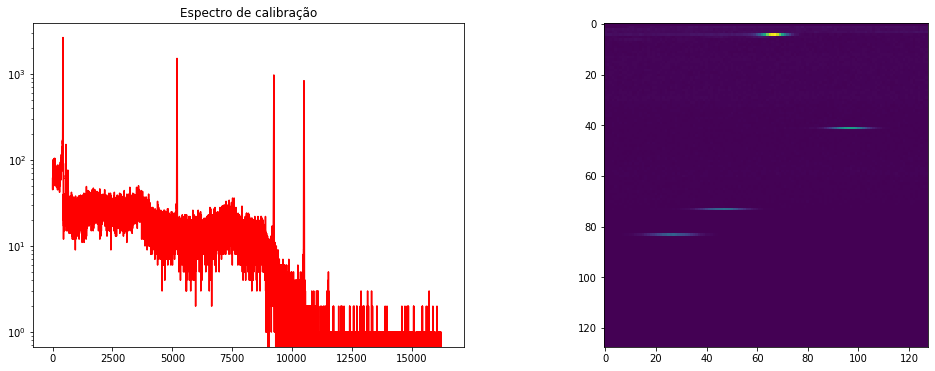

In [278]:
f, axarr = plt.subplots(1, 2, figsize=(17, 3))
axarr[0].plot(df_triplice['channel'], df_triplice.counts.shift(-145).fillna(0).values, 'r')
axarr[0].set_title("Espectro de calibração")
axarr[0].set_yscale("log")
axarr[1].imshow(np.array(dados).reshape((128,128)))

plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

In [279]:
shift_ = 0
dados = df_triplice.counts.shift(shift_).fillna(0).values

preds = model.predict(np.array([dados.reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': np.exp(preds[1][0]),
                   'real_counts': np.sum(dados)})
df

,radionuclideo,nuclei_score,nuclei_counts,real_counts
0,Am-241,99.96,"112,594.37","276,428.00"
1,Ba-133,0.19,0.95,"276,428.00"
2,Cd-109,0.14,0.81,"276,428.00"
3,Co-57,0.82,2.22,"276,428.00"
4,Co-60,100.00,"265,063.16","276,428.00"
5,Cs-137,100.00,"136,013.83","276,428.00"
6,Eu-152,0.02,1.49,"276,428.00"
7,Mn-54,0.46,1.33,"276,428.00"
8,Na-22,0.02,1.11,"276,428.00"
9,Pb-210,0.04,0.78,"276,428.00"


# Validando a atividade com um espectro simulado

In [280]:
df_am241 = carrega_dados('../dados_v5/Am-241_46cm_1-0e08estories_-1.dat', 1e8)

/home/andre/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [237]:
!cat ../dados_v5/Am-241_46cm_1-0e08estories_-1.dat

#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# [SECTION REPORT PULSE HEIGHT SPECTRUM2]
# Units are 1/eV per history
#
# Detection material:
#  4
# Number of energy bins:
#  16384
# Energy bin width (eV):
#   1.25689E+02
#
# For plotting purposes, two values per energy bin are given, namely, the low end and the middle point of each bin.
#
# Elow(eV) : Emiddle(eV) : counts(1/eV/hist) : +-2sigma : nbin
  0.00000E+00  6.28444E+01  0.00000E+00  0.0E+00 1
  1.25689E+02  1.88533E+02  0.00000E+00  0.0E+00 2
  2.51378E+02  3.14222E+02  0.00000E+00  0.0E+00 3
  3.77067E+02  4.39911E+02  0.00000E+00  0.0E+00 4
  5.02756E+02  5.65600E+02  0.00000E+00  0.0E+00 5
  6.28444E+02  6.91289E+02  0.00000E+00  0.0E+00 6
  7.54133E+02  8.16978E+02  0.00000E+00  0.0E+00 7
  8.79822E+02  9.42667E+02  0.00000E+00  0.0E+00 8
  1.00551E+03  1.06836E+03  0.00000E+00  0.0E+00 9
  1.13120E+03  1.19404E+03  0.00000E+00  0.0E+00 10
  1.25689E+03  1.31973E+03  0.00000E+00  0.0E+00 11
  1.38258E+03  1.

  1.30415E+06  1.30421E+06  0.00000E+00  0.0E+00 10377
  1.30427E+06  1.30434E+06  0.00000E+00  0.0E+00 10378
  1.30440E+06  1.30446E+06  0.00000E+00  0.0E+00 10379
  1.30452E+06  1.30459E+06  0.00000E+00  0.0E+00 10380
  1.30465E+06  1.30471E+06  0.00000E+00  0.0E+00 10381
  1.30478E+06  1.30484E+06  0.00000E+00  0.0E+00 10382
  1.30490E+06  1.30496E+06  0.00000E+00  0.0E+00 10383
  1.30503E+06  1.30509E+06  0.00000E+00  0.0E+00 10384
  1.30515E+06  1.30522E+06  0.00000E+00  0.0E+00 10385
  1.30528E+06  1.30534E+06  0.00000E+00  0.0E+00 10386
  1.30540E+06  1.30547E+06  0.00000E+00  0.0E+00 10387
  1.30553E+06  1.30559E+06  0.00000E+00  0.0E+00 10388
  1.30566E+06  1.30572E+06  0.00000E+00  0.0E+00 10389
  1.30578E+06  1.30584E+06  0.00000E+00  0.0E+00 10390
  1.30591E+06  1.30597E+06  0.00000E+00  0.0E+00 10391
  1.30603E+06  1.30610E+06  0.00000E+00  0.0E+00 10392
  1.30616E+06  1.30622E+06  0.00000E+00  0.0E+00 10393
  1.30628E+06  1.30635E+06  0.00000E+00  0.0E+00 10394
  1.30641E

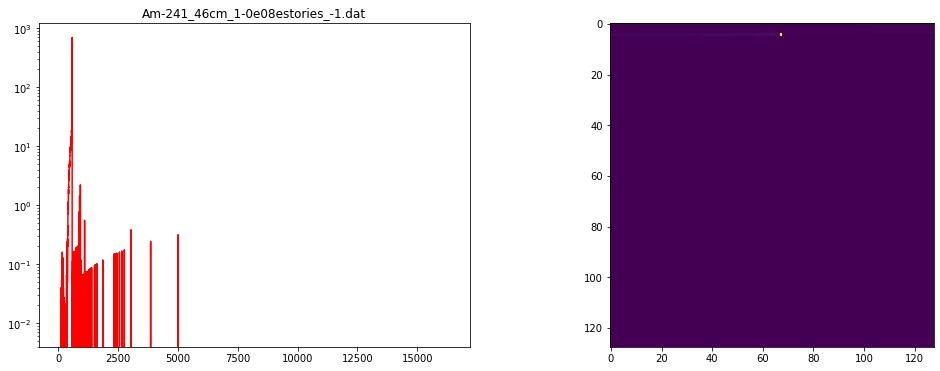

In [281]:
f, axarr = plt.subplots(1, 2, figsize=(17, 3))
axarr[0].plot(df_am241['nbin'], df_am241.counts.values, 'r')
axarr[0].set_title("Am-241_46cm_1-0e08estories_-1.dat")
axarr[0].set_yscale("log")
axarr[1].imshow(np.array(df_am241.counts.values).reshape((128,128)))

plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

In [ ]:
# Performance report
#   Random seeds:
#   1518110056
#    232606248
#   No. of histories simulated [N]:
#           100000000.
#   CPU time [t] (s):
#    7.03350E+02
#   Speed (histories/s):
#    1.42177E+05
#   Average uncertainty (above 1/2 max score) in % [uncert]:
#    1.45326E+00
#   Intrinsic efficiency [N*uncert^2]^-1:
#    4.73490E-09
#   Absolute efficiency [t*uncert^2]^-1:
#    6.73192E-04

In [1]:
94_495_904 / 1e8

0.94495904

In [4]:
(1e8 - 94495904) / 1e8 * 100

5.504096

In [282]:
preds = model.predict(np.array([df_am241.counts.values.reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': np.exp(preds[1][0]),
                   'real_counts': np.sum(df_am241.counts.values)})
df = df.set_index('radionuclideo')
df

,nuclei_score,nuclei_counts,real_counts
radionuclideo,,,
Am-241,99.15,"94,495,904.00","2,203.19"
Ba-133,0.77,0.70,"2,203.19"
Cd-109,13.96,4.50,"2,203.19"
Co-57,0.58,0.86,"2,203.19"
Co-60,0.00,0.77,"2,203.19"
Cs-137,0.16,1.18,"2,203.19"
Eu-152,0.00,0.90,"2,203.19"
Mn-54,0.03,1.15,"2,203.19"
Na-22,0.00,0.91,"2,203.19"


In [ ]:
from scipy.signal import find_peaks

In [ ]:
largura = 350

In [ ]:
peaks, _ = find_peaks(df_am241.counts.values, prominence=2e1)
plt.plot(df_am241.counts.values)
plt.plot(peaks, df_am241.counts[peaks], "x")
plt.plot(np.zeros_like(df_am241.counts), "--", color="gray")

plt.axvline(peaks[0]-largura, 0, 1e4, label='pyplot vertical line', color="red")
plt.axvline(peaks[0]+largura, 0, 1e4, label='pyplot vertical line', color="red")

plt.yscale("log")
plt.show()

In [ ]:
values = []
for idx, peak in enumerate(peaks):
    print(idx)
    data_aux = df_am241[peak-(largura+1*idx):peak+(largura+1*idx)]
    values.append(np.trapz(data_aux['counts'], data_aux['nbin']))
values, np.sum(values)

In [ ]:
def print_formatado(x):
    return "{:4.4e}".format(x)

In [ ]:
eff = np.sum(values) / 1e8
print_formatado(eff)

In [ ]:
atividade = df.loc['Am-241'].nuclei_counts / eff
print_formatado(atividade), atividade / 1e8

## Para Co-60

In [284]:
df_co60 = carrega_dados('../dados_v5/Co-60_56cm_1-0e08estories_-1.dat', 1e8)

/home/andre/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
!cat ../dados_v5/Co-60_56cm_1-0e08estories_-1.dat

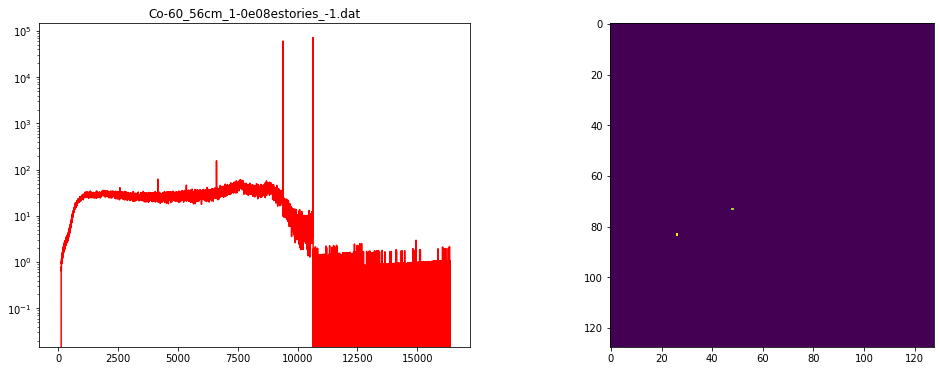

In [285]:
f, axarr = plt.subplots(1, 2, figsize=(17, 3))
axarr[0].plot(df_co60['nbin'], df_co60.counts.values, 'r')
axarr[0].set_title("Co-60_56cm_1-0e08estories_-1.dat")
axarr[0].set_yscale("log")
axarr[1].imshow(np.array(df_co60.counts.values).reshape((128,128)))

plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

In [5]:
140_471_232 / 1e8

1.40471232

In [7]:
(1e8 - 140_471_232) / 1e8 * 100

-40.471232

In [286]:
preds = model.predict(np.array([df_co60.counts.values.reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_counts': np.exp(preds[1][0]),
                   'real_counts': np.sum(df_co60.counts.values)})
df = df.set_index("radionuclideo")
df

,nuclei_score,nuclei_counts,real_counts
radionuclideo,,,
Am-241,11.34,2.71,"413,587.11"
Ba-133,12.43,2.23,"413,587.11"
Cd-109,14.55,2.44,"413,587.11"
Co-57,9.51,1.81,"413,587.11"
Co-60,99.99,"140,471,232.00","413,587.11"
Cs-137,10.89,2.37,"413,587.11"
Eu-152,11.55,2.50,"413,587.11"
Mn-54,6.11,1.52,"413,587.11"
Na-22,8.98,1.73,"413,587.11"


In [ ]:
peaks, _ = find_peaks(df_co60.counts.values, prominence=2e3)
plt.plot(df_co60.counts.values)
plt.plot(peaks, df_co60.counts[peaks], "x")
plt.plot(np.zeros_like(df_co60.counts), "--", color="gray")
plt.yscale("log")
plt.show()

In [ ]:
largura = 450
values = []
for idx, peak in enumerate(peaks):
    print(idx)
    data_aux = df_co60[peak-(largura+1*idx):peak+(largura+1*idx)]
    values.append(np.trapz(data_aux['counts'], data_aux['nbin']))
values, np.sum(values)

eff = np.mean(np.array(values)) / 1e8
eff, values

In [ ]:
values, np.array(values) / 1e8

In [ ]:
atividade = df.loc['Co-60']['nuclei_counts'] / eff
atividade, atividade / 1e8

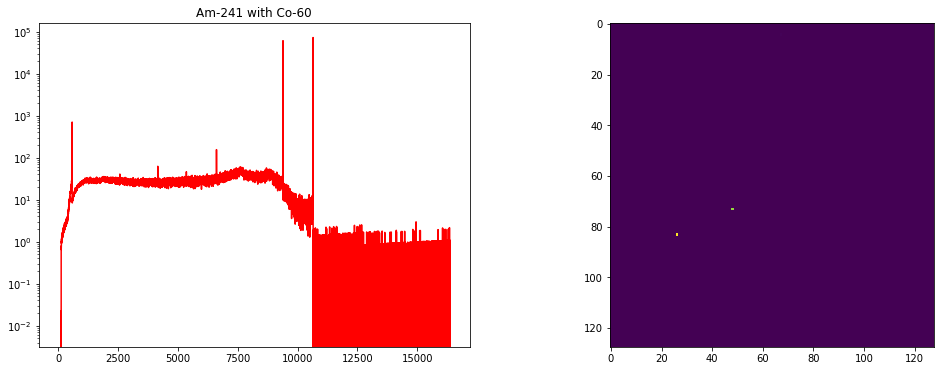

In [290]:
df_am241_co60 = df_am241.counts + df_co60.counts

f, axarr = plt.subplots(1, 2, figsize=(17, 3))
axarr[0].plot(df_am241['nbin'], df_am241_co60.values, 'r')
axarr[0].set_title("Am-241 with Co-60")
axarr[0].set_yscale("log")
axarr[1].imshow(np.array(df_am241_co60.values).reshape((128,128)))

plt.grid(False)
plt.subplots_adjust(bottom=1.25, top=2.75)
plt.show()

In [297]:
preds = model.predict(np.array([df_am241_co60.values.reshape((128, 128, 1))]))

df = pd.DataFrame({'radionuclideo':binarizer.classes_,
                   'nuclei_score': preds[0][0]*100,
                   'nuclei_activity': np.exp(preds[1][0]),
                   'real_activity': [1e8, 0, 0, 0, 1e8, 0, 0, 0, 0, 0],
                   'diff': np.exp(preds[1][0]) / np.array([1e8, 0, 0, 0, 1e8, 0, 0, 0, 0, 0])
                  })
df = df.set_index("radionuclideo")
df

/home/andre/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


,nuclei_score,nuclei_activity,real_activity,diff
radionuclideo,,,,
Am-241,99.90,"50,152,716.00","100,000,000.00",0.50
Ba-133,9.88,1.78,0.00,inf
Cd-109,17.26,6.99,0.00,inf
Co-57,5.55,1.56,0.00,inf
Co-60,99.99,"134,546,528.00","100,000,000.00",1.35
Cs-137,44.49,6.04,0.00,inf
Eu-152,27.13,4.90,0.00,inf
Mn-54,14.27,1.93,0.00,inf
Na-22,7.90,1.79,0.00,inf


In [9]:
(1e8 - 50_152_716) / 1e8 * 100, (1e8 - 134_546_528) / 1e8 * 100

(49.847283999999995, -34.546527999999995)